# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [53]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

from matplotlib import animation

In [42]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.523385380551301


## Level 0->1 Coarsening

### Relaxation

In [112]:
def animate_method_shrinkage(
    info, show: bool = True, save: bool = False, file_name: str = None,
    duration: float = 2):
    factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = info

    n = x_history[0].shape[0]
    # First set up the figure, the axis, and the plot element we want to animate
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_xticks(x_ticks)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    line0 = ax.plot([], [], "o", color=color)[0]
    scatter0 = ax.scatter([], [], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor", fontsize=14)
    ax.set_xlabel("Sweep #", fontsize=14)
    #ax.grid(True)

    ax = axs[1]
    ax.clear()
    line1 = ax.plot([], [])[0]
    x_init = x_history[0][:, 0]
    ax.set_xlim([0, n - 1])
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error", fontsize=14)

    ax = axs[2]
    ax.clear()
    line2 = ax.plot([], [])[0]
    r_init = r_history[0][:, 0]
    ax.set_xlim([0, n - 1])
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual", fontsize=14)

    # initialization function: plot the background of each frame
    def init():
        line0.set_data([], [])
        line1.set_data([], [])
        line2.set_data([], [])
        return line0, line1, line2

    # animation function.  This is called sequentially
    def animate(i):
        line0.set_data(x_ticks[:(i + 1)], conv[:(i + 1)])
        if i >= num_sweeps:
            scatter0.set_offsets(np.c_[[num_sweeps], [conv[num_sweeps - 1]]])
        line1.set_data(np.arange(n), x_history[i][:, 0])
        line2.set_data(np.arange(n), r_history[i][:, 0])
        axs[1].set_title("Error after {} sweeps".format(i), fontsize=14)
        axs[2].set_title("Residual after {} sweeps".format(i), fontsize=14)
        return line0, scatter0, line1, line2

    # call the animator.  blit=True means only re-draw the parts that have changed.
    num_frames = len(r_history)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=num_frames, interval=duration / num_frames, blit=True)
    fig.set_size_inches(18, 4)
    if save:
        anim.save(file_name, dpi=300, fps=num_frames / duration, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
    if show:
        video = anim.to_html5_video()
        html = display.HTML(video)
        display.display(html)
    plt.close()

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.351e+00                    4.471e-01    3.026
INFO     1     5.431e-01 (0.403) [0.403]    2.654e-01    2.074 (0.683)
INFO     2     2.279e-01 (0.420) [0.412]    1.968e-01    1.193 (0.572)
INFO     3     1.032e-01 (0.453) [0.425]    1.676e-01    0.641 (0.536)
INFO     4     5.205e-02 (0.504) [0.444]    1.521e-01    0.357 (0.558)
INFO     5     3.028e-02 (0.582) [0.469]    1.422e-01    0.222 (0.624)
INFO     6     2.011e-02 (0.663) [0.497]    1.351e-01    0.154 (0.699)
INFO     7     1.481e-02 (0.735) [0.526]    1.296e-01    0.118 (0.767)
INFO     8     1.164e-02 (0.784) [0.553]    1.253e-01    0.096 (0.813)
INFO     9     9.525e-03 (0.818) [0.578]    1.217e-01    0.081 (0.843)
INFO     10    8.000e-03 (0.839) [0.600]    1.186e-01    0.069 (0.862)
INFO     11    6.844e-03 (0.855) [0.619]    1.160e-01    0.061 (0.875)
INFO     12    5.934e-03 (0.867) [0.637]    1.137e-01    0.054 (0.885)
INFO 

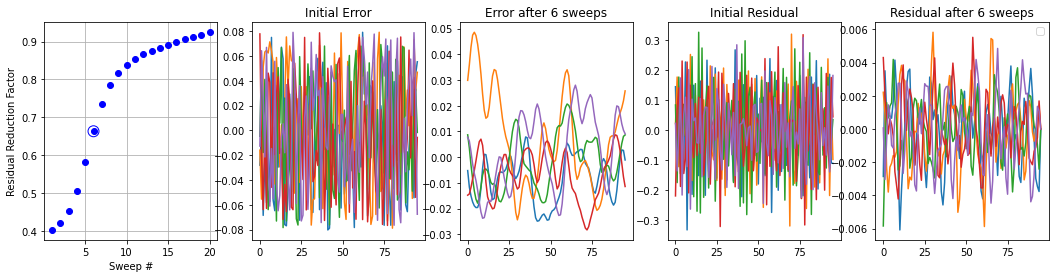

In [116]:
kh = 0

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []


method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

# Generate animation video of Laplace/GS shrinkage.
info = method_info["Kaczmarz"]
animate_method_shrinkage(method_info["Kaczmarz"], show=False, save=True, file_name="laplace_shrinkage.mp4",
                        duration=2.0)

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.341e+00                    4.460e-01    3.001
INFO     1     4.263e-01 (0.318) [0.318]    2.914e-01    1.464 (0.487)
INFO     2     1.807e-01 (0.423) [0.367]    2.531e-01    0.716 (0.488)
INFO     3     1.079e-01 (0.597) [0.432]    2.370e-01    0.457 (0.638)
INFO     4     8.109e-02 (0.753) [0.496]    2.269e-01    0.359 (0.787)
INFO     5     6.796e-02 (0.840) [0.551]    2.194e-01    0.312 (0.869)
INFO     6     6.005e-02 (0.885) [0.597]    2.133e-01    0.283 (0.911)
INFO     7     5.463e-02 (0.911) [0.634]    2.080e-01    0.265 (0.934)
INFO     8     5.059e-02 (0.926) [0.665]    2.033e-01    0.251 (0.948)
INFO     9     4.738e-02 (0.937) [0.691]    1.991e-01    0.240 (0.957)
INFO     10    4.474e-02 (0.944) [0.713]    1.952e-01    0.231 (0.963)
INFO     11    4.249e-02 (0.950) [0.732]    1.917e-01    0.223 (0.967)
INFO     12    4.053e-02 (0.954) [0.748]    1.884e-01    0.217 (0.971)
INFO 

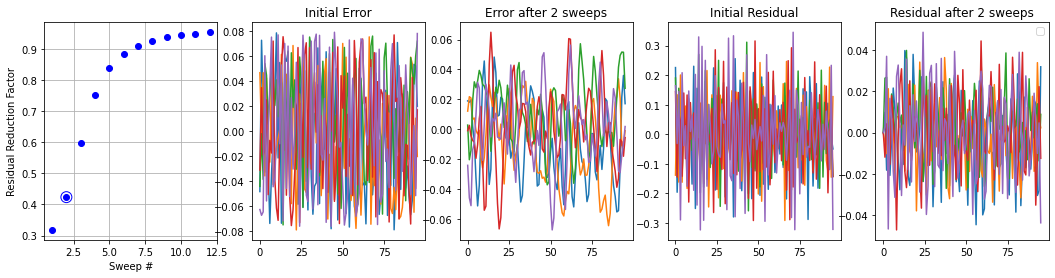

In [193]:
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
symmetrize = False # True

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(
    a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None, symmetrize=symmetrize)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

# Generate animation video of Laplace/GS shrinkage.
info = method_info["Kaczmarz"]
animate_method_shrinkage(method_info["Kaczmarz"], show=False, save=True, file_name="kaczmarz_shrinkage.mp4",
                        duration=2.0)

In [194]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 30 sweeps
INFO     RER 0.141


### Coarsening: Fixed (4/2)

In [195]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

In [250]:
def animate_method_coarsening(
    level, num_sweeps: int, aggregate_size: int, num_components: int, file_name: str,
    duration: float = 2):

    # Create relaxed TVs.
    global x_tf
    colors = ("red", "green", "blue", "magenta")
    x_tf = hm.solve.run.random_test_matrix((level.a.shape[0],), num_examples=4)
    b = np.zeros_like(x_tf)
    x_ticks = np.arange(aggregate_size)

    # Set up initial figure.
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    ax = axs[0]
    # R should be real-valued, but cast just in case.
    r_lines = []
    for i in range(num_components):
        line = ax.plot([], [], color=colors[i])[0]
        r_lines.append(line)
    ax.set_xticks(x_ticks)
    ax.set_xlim([0, aggregate_size - 1])
    ax.set_ylim([-1, 1])
#    ax.set_title(r"$a = {}, n_c = {}$".format(aggregate_size, num_components), fontsize=14)
    ax.set_ylabel(r"Principal Components", fontsize=14)
    ax.grid(True)
    text = ax.text((aggregate_size - 1) / 2 - 0.1 * aggregate_size / 4, 1.05, "$\\nu = 0$", fontsize=12)

    # Singular values, normalized to sigma_max = 1.
    ax = axs[1]
    s_scatter = ax.scatter([], [], 120, facecolors='none', edgecolors="#994c00")
    ax.set_xticks(x_ticks)
    ax.set_xlim([-0.1, aggregate_size - 1 + 0.1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel(r"$i$")
    ax.set_ylabel(r"$\sigma_i$", fontsize=14)
    s_text = []
    for xi in x_ticks:
        si_text = ax.text(xi - 0.1 * aggregate_size / 3, 1.08, "$-$", fontsize=12)
        s_text.append(si_text)

    # initialization function: plot the background of each frame
    def init():
        for line in r_lines:
            line.set_data([], [])
        return r_lines + [s_scatter]

    # animation function.  This is called sequentially
    def animate(i):
        global x_tf
        x_tf = hm.solve.run.run_iterative_method(
           level.operator, lambda x: level.relax(x, b), x_tf, num_sweeps=1)[0]
        r, s = hm.repetitive.locality.create_coarsening(x_tf, aggregate_size, num_components, normalize=False)
        r = hm.linalg.normalize_signs(r.asarray(), axis=0)
        x_ticks = np.arange(aggregate_size)
        for j, line in enumerate(r_lines):
            line.set_data(x_ticks, r[j])
        sn = s / s[0]
        energy_error = (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5
        s_scatter.set_offsets(np.c_[x_ticks, sn])
        if i % 10 == 0:
            print("Frame {} s {}".format(i, sn))
            #print(r)
        text.set_text("$\\nu = {}$".format(i))
        for si_text, e in zip(s_text, energy_error):
            si_text.set_text("${:.3f}$".format(e))
        return r_lines + [s_scatter] + [text] + s_text

    # call the animator.  blit=True means only re-draw the parts that have changed.
    num_frames = num_sweeps
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=num_frames, interval=duration / num_frames, blit=True)
    fig.set_size_inches(12, 4)
    anim.save(file_name, dpi=300, fps=num_frames / duration, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])

INFO     Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO     MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3600x1200 -pix_fmt rgba -r 67.0 -loglevel error -i pipe: -vcodec h264 -vcodec libx264 -pix_fmt yuv420p -y r_4_2_vs_smoothing.mp4
Frame 0 s [1.    0.678 0.378 0.234]
Frame 10 s [1.    0.516 0.101 0.023]
Frame 20 s [1.    0.536 0.076 0.017]
Frame 30 s [1.    0.552 0.063 0.014]
Frame 40 s [1.    0.565 0.056 0.013]
Frame 50 s [1.    0.574 0.051 0.011]
Frame 60 s [1.    0.582 0.047 0.011]
Frame 70 s [1.    0.589 0.044 0.01 ]
Frame 80 s [1.    0.594 0.042 0.009]
Frame 90 s [1.    0.599 0.04  0.009]
Frame 100 s [1.    0.603 0.039 0.009]
Frame 110 s [1.    0.606 0.038 0.008]
Frame 120 s [1.    0.609 0.036 0.008]
Frame 130 s [1.    0.612 0.035 0.008]
Frame 140 s [1.    0.614 0.034 0.007]
Frame 150 s [1.    0.616 0.033 0.007]
Frame 160 s [1.    0.618 0.033 0.007]
Frame 170 s [1.    0.619 0.032 0.007]
Frame 180 s [1.    0.621 0.031 0.007]
Fra

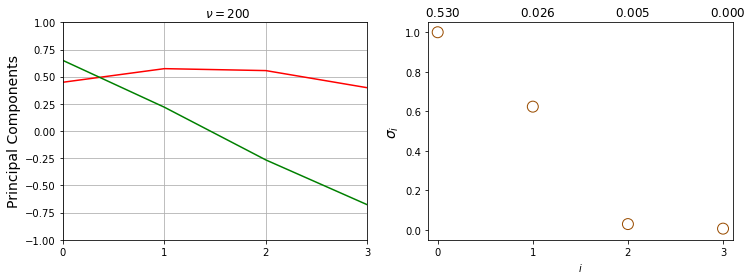

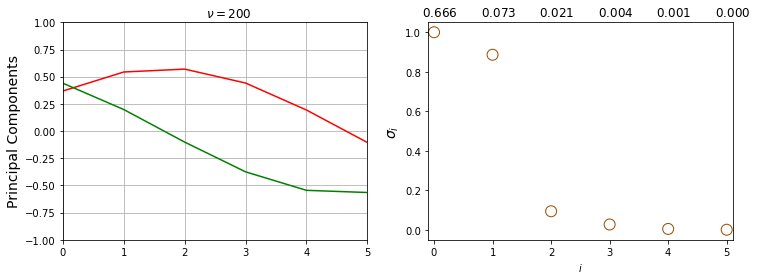

In [252]:
animate_method_coarsening(level, 201, 4, 2, "r_4_2_vs_smoothing.mp4", duration=3)
animate_method_coarsening(level, 201, 6, 2, "r_6_2_vs_smoothing.mp4", duration=3)

,0,1,2,3,4,5,6,7,8,9
0,-0.4114,-0.5550,-0.5680,-0.4474,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6735,0.2625,-0.2314,-0.6511,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.4114,-0.5550,-0.5680,-0.4474,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.6735,0.2625,-0.2314,-0.6511,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.4114,-0.5550


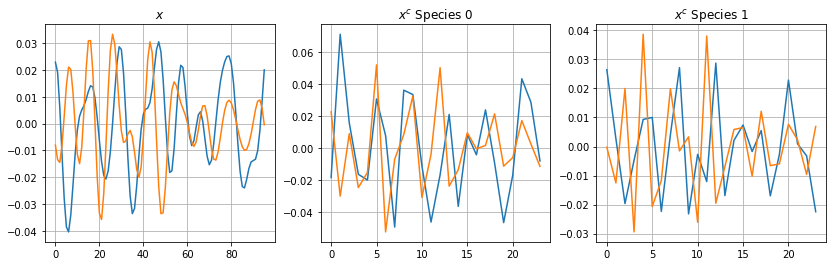

In [197]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

4 2


,0,1,2,3,4,5,6,7,8,9
0,-0.4114,-0.5550,-0.5680,-0.4474,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6735,0.2625,-0.2314,-0.6511,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.4114,-0.5550,-0.5680,-0.4474,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.6735,0.2625,-0.2314,-0.6511,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.4114,-0.5550


INFO     Mock cycle conv |domain|=24 [0.501 0.292 0.167 0.106 0.08  0.071 0.058 0.04 ]
INFO     Mock cycle eff |domain|=24 [0.708 0.735 0.742 0.756 0.777 0.802 0.816 0.818]
6 2


,0,1,2,3,4,5,6,7,8,9
0,-0.2727,-0.4597,-0.5463,-0.5116,-0.3646,-0.1451,0.0000,0.0000,0.0000,0.0000
1,0.5198,0.3669,0.0928,-0.2149,-0.4611,-0.5725,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.2727,-0.4597,-0.5463,-0.5116
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5198,0.3669,0.0928,-0.2149
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


INFO     Mock cycle conv |domain|=36 [0.833 0.725 0.544 0.473 0.457 0.316 0.338 0.285]
INFO     Mock cycle eff |domain|=36 [0.885 0.898 0.873 0.883 0.901 0.88  0.902 0.901]
6 3


,0,1,2,3,4,5,6,7,8,9
0,-0.2727,-0.4597,-0.5463,-0.5116,-0.3646,-0.1451,0.0000,0.0000,0.0000,0.0000
1,0.5198,0.3669,0.0928,-0.2149,-0.4611,-0.5725,0.0000,0.0000,0.0000,0.0000
2,0.6376,0.0672,-0.3036,-0.3029,0.0665,0.6329,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.2727,-0.4597,-0.5463,-0.5116
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5198,0.3669,0.0928,-0.2149


INFO     Mock cycle conv |domain|=36 [0.522 0.286 0.177 0.118 0.098 0.078 0.064 0.053]
INFO     Mock cycle eff |domain|=36 [0.722 0.732 0.749 0.766 0.793 0.809 0.822 0.832]


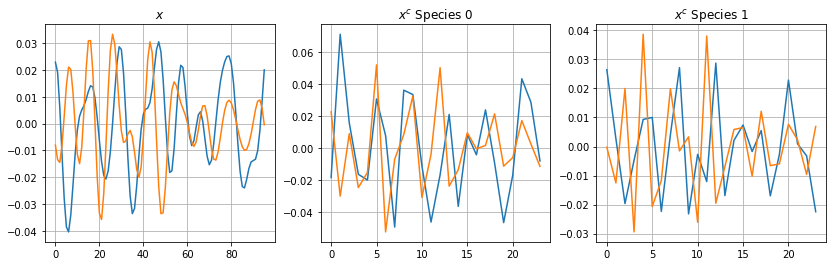

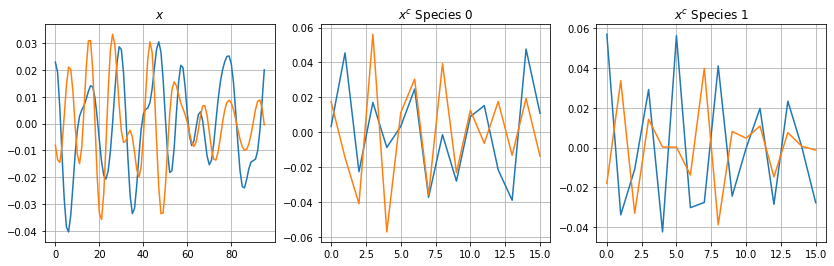

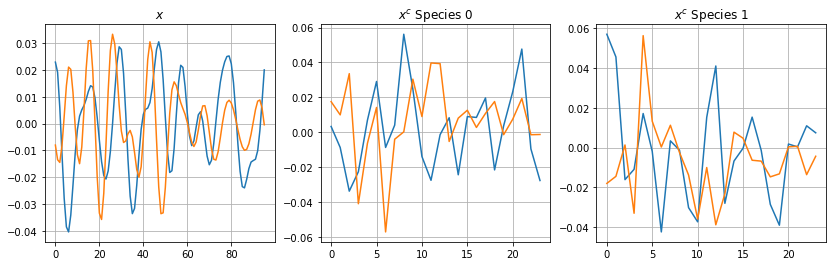

In [234]:
coarsening_types = [(4, 2), (6, 2), (6, 3)]
num_sweeps = 8
m = 6

for aggregate_size, num_components in coarsening_types:
    print(aggregate_size, num_components)
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    R = r.tile(level.size // aggregate_size)
    xc = R.dot(x)
    display(pd.DataFrame(R[:5,:10].todense()))
    hm.repetitive.locality.plot_coarsening(R, x)

    # Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
    nu_values = np.arange(1, num_sweeps + 1)
    work = nu_values / (1 - num_components / aggregate_size)
    mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
    _LOGGER.info("Mock cycle conv |domain|={} {}".format(
        m * aggregate_size, np.array2string(mock_conv, precision=3)))
    _LOGGER.info("Mock cycle eff |domain|={} {}".format(
        m * aggregate_size, np.array2string(mock_conv ** (1/work), precision=3)))


### Interpolation $P = R^T$

In [476]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.83


### Interpolation by LS Fitting

In [477]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.54,0.31,0.17,0.12,0.14,0.11,0.09,0.07
P=R^T,nan,nan,nan,nan,nan,0.53,0.37,0.48,0.48,0.45,0.44,0.43,0.42
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.53,0.38,0.46,0.49,0.43,0.42,0.43,0.41
P^T A P caliber 3,0.00,3.00,288.00,1.40,0.00,0.61,0.33,0.25,0.31,0.28,0.23,0.23,0.22
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.59,0.34,0.22,0.14,0.16,0.14,0.10,0.08
R A P caliber 2,1.00,2.00,192.00,1.20,0.01,0.53,0.37,0.46,0.49,0.42,0.40,0.42,0.41
R A P caliber 3,1.00,3.00,288.00,1.20,0.02,0.60,0.35,0.33,0.38,0.32,0.30,0.31,0.30
R A P caliber 4,1.00,4.00,384.00,1.20,0.01,1.31,0.57,0.46,0.21,0.20,0.16,0.11,0.08


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [478]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.4144,0.6862
1,-0.5455,0.2471
2,-0.5632,-0.2330
3,-0.4611,-0.6338


A^1


,0,1,2,3,4,5
0,-0.1903,-0.0374,0.2144,-0.3802,0.2144,0.3133
1,-0.0374,-1.4539,0.3133,-0.5535,-0.3802,-0.5535


caliber 3 P


,0,1,2,3
0,-0.4149,0.5883,0.0000,-0.0642
1,-0.5443,0.3266,0.0000,0.0505
2,-0.5599,-0.2986,0.0473,0.0000
3,-0.4630,-0.5406,-0.0630,0.0000


A^1


,0,1,2,3,4,5,6,7
0,-0.0932,-0.0350,0.1798,-0.2836,0.0037,0.0037,0.1798,0.2308
1,-0.0350,-1.1156,0.2308,-0.3948,0.0000,0.0000,-0.2836,-0.3948


caliber 4 P


,0,1,2,3,4,5
0,-0.3634,0.4434,0.0000,0.0000,-0.1132,-0.1692
1,-0.5853,0.4500,0.0000,0.0000,0.0931,0.1299
2,-0.6047,-0.3905,0.0762,-0.1166,0.0000,0.0000
3,-0.3991,-0.4153,-0.1023,0.1726,0.0000,0.0000


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.0700,-0.0317,0.1593,-0.2553,0.0110,-0.0169,0.0110,0.0154,0.1593,0.2164
1,-0.0317,-0.9809,0.2164,-0.3537,0.0154,-0.0237,-0.0169,-0.0237,-0.2553,-0.3537


R*A*P
caliber 2 P


,0,1
0,-0.4144,0.6862
1,-0.5455,0.2471
2,-0.5632,-0.2330
3,-0.4611,-0.6338


A^1


,0,1,2,3,4,5
0,-0.1894,-0.0359,0.2133,-0.3784,0.2140,0.3128
1,-0.0347,-1.4613,0.3122,-0.5516,-0.3848,-0.5602


caliber 3 P


,0,1,2,3
0,-0.4149,0.5883,0.0000,-0.0642
1,-0.5443,0.3266,0.0000,0.0505
2,-0.5599,-0.2986,0.0473,0.0000
3,-0.4630,-0.5406,-0.0630,0.0000


A^1


,0,1,2,3,4,5
0,-0.1186,-0.0308,0.1915,-0.3200,0.1972,0.2634
1,-0.0404,-1.2336,0.2434,-0.4669,-0.3047,-0.4721


caliber 4 P


,0,1,2,3,4,5
0,-0.3634,0.4434,0.0000,0.0000,-0.1132,-0.1692
1,-0.5853,0.4500,0.0000,0.0000,0.0931,0.1299
2,-0.6047,-0.3905,0.0762,-0.1166,0.0000,0.0000
3,-0.3991,-0.4153,-0.1023,0.1726,0.0000,0.0000


A^1


,0,1,2,3,4,5
0,-0.0317,-0.0186,0.1471,-0.1734,0.1494,0.1498
1,-0.0306,-0.6004,0.1556,-0.1517,-0.1812,-0.1375


In [479]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[True][-1]  # R*A*P P high order
#p = p_experiment[True][0]  # R*A*P P=R^T

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.831e+01 RER 3.40889
INFO         1 |r| 5.120e+00 (0.27972) RER 0.58916 (0.17283) 8.691
INFO         2 |r| 1.362e+00 (0.26598) RER 0.18010 (0.30570) 7.562
INFO         3 |r| 5.425e-01 (0.39833) RER 0.07913 (0.43935) 6.856
INFO         4 |r| 2.060e-01 (0.37980) RER 0.03016 (0.38118) 6.831
INFO         5 |r| 8.977e-02 (0.43568) RER 0.01310 (0.43438) 6.852
INFO         6 |r| 3.885e-02 (0.43283) RER 0.00567 (0.43283) 6.852
INFO         7 |r| 1.749e-02 (0.45009) RER 0.00255 (0.45000) 6.853
INFO         8 |r| 7.865e-03 (0.44975) RER 0.00115 (0.44978) 6.853
INFO         9 |r| 3.569e-03 (0.45373) RER 0.00052 (0.45372) 6.853
INFO        10 |r| 1.617e-03 (0.45321) RER 0.00024 (0.45321) 6.853
INFO        11 |r| 7.368e-04 (0.45553) RER 0.00011 (0.45553) 6.853
INFO        12 |r| 3.369e-04 (0.45723) RER 0.00005 (0.45723) 6.853
INFO        13 |r| 1.546e-04 (0.45897) RER 0.00002 (0.45897) 6.853
INFO        14 |r| 7.109e-05 (0.45976) RER 0.00001 (0.45976) 6.853
INFO        15 |r| 3.

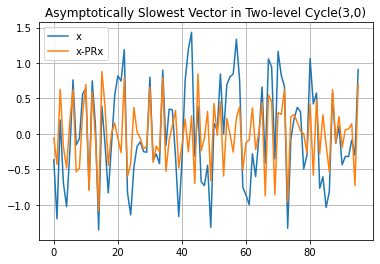

In [480]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3
use_r_as_restriction = True

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [481]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.151 -0.151  0.167  0.167]


In [482]:
m0[1].a

<48x48 sparse matrix of type '<class 'numpy.float64'>'
	with 288 stored elements in Compressed Sparse Row format>

In [483]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,-0.0317,-0.0186,0.1471,-0.1734,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0306,-0.6004,0.1556,-0.1517,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.1494,0.1498,-0.0317,-0.0186,0.1471,-0.1734,0.0000,0.0000,0.0000,0.0000
3,-0.1812,-0.1375,-0.0306,-0.6004,0.1556,-0.1517,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.1494,0.1498,-0.0317,-0.0186,0.1471,-0.1734,0.0000,0.0000
5,0.0000,0.0000,-0.1812,-0.1375,-0.0306,-0.6004,0.1556,-0.1517,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.1494,0.1498,-0.0317,-0.0186,0.1471,-0.1734
7,0.0000,0.0000,0.0000,0.0000,-0.1812,-0.1375,-0.0306,-0.6004,0.1556,-0.1517
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1494,0.1498,-0.0317,-0.0186
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.1812,-0.1375,-0.0306,-0.6004


In [484]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,0.0121,-0.0023,0.0078,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0121,0.0000,0.0059,-0.0142,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0023,-0.0059,0.0000,0.0121,-0.0023,0.0078,0.0000,0.0000,0.0000,0.0000
3,-0.0078,0.0142,-0.0121,0.0000,0.0059,-0.0142,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0023,-0.0059,0.0000,0.0121,-0.0023,0.0078,0.0000,0.0000
5,0.0000,0.0000,-0.0078,0.0142,-0.0121,0.0000,0.0059,-0.0142,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0023,-0.0059,0.0000,0.0121,-0.0023,0.0078
7,0.0000,0.0000,0.0000,0.0000,-0.0078,0.0142,-0.0121,0.0000,0.0059,-0.0142
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0023,-0.0059,0.0000,0.0121
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0078,0.0142,-0.0121,0.0000


<!-- #### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil. -->

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [485]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [486]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.452e-01                    4.456e-01    0.552
INFO     1     8.817e-02 (0.358) [0.358]    2.541e-01    0.347 (0.631)
INFO     2     4.780e-02 (0.546) [0.441]    1.879e-01    0.256 (0.739)
INFO     3     2.885e-02 (0.600) [0.490]    1.585e-01    0.184 (0.714)
INFO     4     2.130e-02 (0.745) [0.543]    1.402e-01    0.154 (0.844)
INFO     5     1.641e-02 (0.773) [0.582]    1.282e-01    0.130 (0.846)
INFO     6     1.346e-02 (0.821) [0.617]    1.198e-01    0.114 (0.880)
INFO     7     1.153e-02 (0.855) [0.646]    1.133e-01    0.103 (0.904)
INFO     8     1.019e-02 (0.881) [0.672]    1.082e-01    0.095 (0.924)
INFO     9     9.189e-03 (0.899) [0.695]    1.038e-01    0.089 (0.937)
INFO     10    8.398e-03 (0.911) [0.714]    1.000e-01    0.084 (0.945)
INFO     11    7.745e-03 (0.919) [0.731]    9.672e-02    0.080 (0.951)
INFO     12    7.191e-03 (0.926) [0.745]    9.377e-02    0.077 (0.955)
INFO 

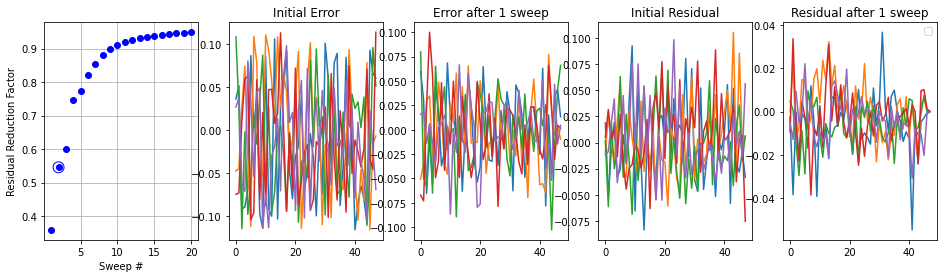

In [487]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

,0,1,2,3
0,0.6533,-0.2703,-0.6719,-0.2206
1,-0.4927,-0.5073,-0.4531,0.5427


nu 100 s [1.    0.809 0.005 0.001] Energy error [0.629 0.004 0.001 0.   ]
INFO     Mock cycle conv [0.353 0.18  0.126 0.101 0.064 0.084 0.067 0.05  0.035 0.03  0.023]


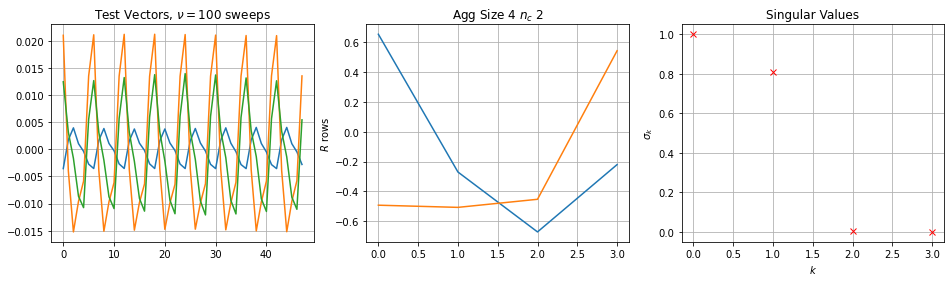

In [488]:

# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [489]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.1494,0.1498,-0.0317,-0.0186,0.1471,-0.1734
1,-0.1812,-0.1375,-0.0306,-0.6004,0.1556,-0.1517


In [490]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.002


In [491]:
#plt.plot(x[:, 0][1::2])
#plt.plot(x[:, 1][1::2])
#plt.plot(x[:, 2][1::2])

#plt.plot(x[:, 1])

In [492]:
# def autocorr(x):
#     result = np.correlate(x, x, mode='full')
#     return result[result.size//2:]

In [493]:
 # np.correlate(x[:, 0], x[:, 0], mode='full')

[1.    0.803 0.005 0.001]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,-0.6250,0.2978,0.6961,0.1904,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.5275,0.4921,0.4148,-0.5545,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.6250,0.2978,0.6961,0.1904,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.5275,0.4921,0.4148,-0.5545,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.6250,0.2978


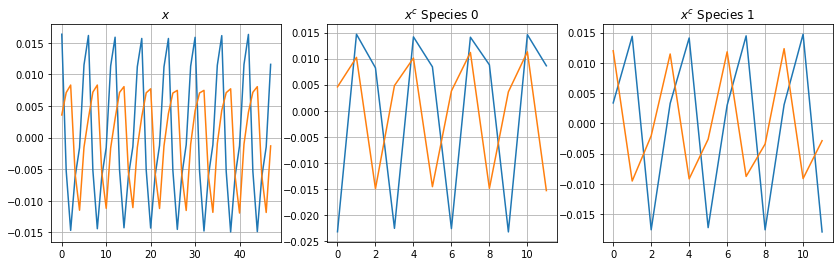

In [494]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Mock Cycle Rate

In [495]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.354 0.213 0.142 0.121 0.098 0.082 0.067 0.052 0.04  0.034 0.025]


In [496]:
# hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]
# num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
# num_coarse_vars = nc * num_aggregates
# np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

### Interpolation $P = R^T$

In [497]:
#### Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(level.size // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(level.a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 0.45


### Interpolation by LS Fitting

In [498]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        #print(a.shape, R.shape, level.location.shape)
        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.35,0.21,0.14,0.12,0.10,0.08,0.07,0.05,0.04,0.03,0.02
P=R^T,nan,nan,nan,nan,nan,8.98,5.72,5.19,4.26,3.58,2.97,2.47,2.04,1.67,1.36,1.14
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.01,9.12,5.80,5.27,4.33,3.63,3.02,2.50,2.07,1.70,1.41,1.11
P^T A P caliber 3,0.00,3.00,144.00,1.17,0.00,1.03,0.65,0.37,0.19,0.14,0.11,0.10,0.09,0.07,0.06,0.06
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.00,1.98,1.05,0.46,0.26,0.15,0.09,0.04,0.03,0.03,0.05,0.05
R A P caliber 2,1.00,2.00,96.00,1.00,0.01,9.06,5.76,5.23,4.30,3.61,3.00,2.49,2.06,1.70,1.34,1.16
R A P caliber 3,1.00,3.00,144.00,1.00,0.01,1.39,1.16,0.68,0.45,0.32,0.27,0.23,0.19,0.17,0.12,0.12
R A P caliber 4,1.00,4.00,192.00,1.00,0.02,4.75,2.25,0.38,0.20,0.13,0.07,0.07,0.06,0.04,0.03,0.03


### Solving $Ax = b$ - Convergence History

INFO         0 |r| 3.239e+00 RER 0.74689
INFO         1 |r| 2.560e+00 (0.79030) RER 0.37087 (0.49656) 6.903
INFO         2 |r| 3.026e+00 (1.18198) RER 0.47384 (1.27764) 6.386
INFO         3 |r| 5.702e+00 (1.88449) RER 0.45303 (0.95609) 12.587
INFO         4 |r| 1.198e+01 (2.10005) RER 0.52558 (1.16012) 22.785
INFO         5 |r| 2.486e+01 (2.07610) RER 0.50528 (0.96139) 49.204
INFO         6 |r| 5.089e+01 (2.04708) RER 0.51627 (1.02174) 98.582
INFO         7 |r| 1.031e+02 (2.02529) RER 0.50902 (0.98596) 202.500
INFO         8 |r| 2.069e+02 (2.00765) RER 0.50952 (1.00099) 406.149
INFO         9 |r| 4.126e+02 (1.99397) RER 0.50596 (0.99301) 815.548
INFO        10 |r| 8.198e+02 (1.98673) RER 0.50396 (0.99605) 1626.705
INFO        11 |r| 1.632e+03 (1.99071) RER 0.50126 (0.99463) 3255.784
INFO        12 |r| 3.284e+03 (2.01257) RER 0.49946 (0.99641) 6576.097
INFO        13 |r| 6.761e+03 (2.05838) RER 0.49883 (0.99875) 13553.067
INFO        14 |r| 1.439e+04 (2.12806) RER 0.50011 (1.00257) 2876

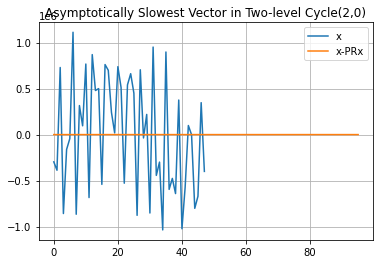

In [499]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 2
p = p_experiment[True][-1]  # P^T*A*P P high order
use_r_as_restriction = True

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [500]:
m1[1].a

<24x24 sparse matrix of type '<class 'numpy.float64'>'
	with 144 stored elements in Compressed Sparse Row format>

In [501]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.151 -0.151  0.167  0.167]
1 lam [-0.    -0.    -0.001 -0.001 -0.019  0.045  0.045  0.061  0.061 -0.073 -0.073  0.087]


## 3-Level Method

In [502]:
m0.add(m1[1])

INFO         0 |r| 1.777e+01 RER 3.16316
INFO         1 |r| 1.272e+00 (0.07158) RER 0.02635 (0.00833) 48.269
INFO         2 |r| 1.406e-01 (0.11052) RER 0.00300 (0.11387) 46.848
INFO         3 |r| 1.811e-02 (0.12882) RER 0.00039 (0.12879) 46.858
INFO         4 |r| 2.388e-03 (0.13185) RER 0.00005 (0.13180) 46.877
INFO         5 |r| 3.461e-04 (0.14496) RER 0.00001 (0.14496) 46.877
INFO         6 |r| 5.041e-05 (0.14565) RER 0.00000 (0.14565) 46.877
INFO         7 |r| 7.480e-06 (0.14839) RER 0.00000 (0.14839) 46.877
INFO         8 |r| 1.159e-06 (0.15493) RER 0.00000 (0.15493) 46.877
INFO         9 |r| 1.791e-07 (0.15454) RER 0.00000 (0.15454) 46.877
INFO        10 |r| 2.816e-08 (0.15720) RER 0.00000 (0.15720) 46.877
INFO        11 |r| 4.394e-09 (0.15605) RER 0.00000 (0.15605) 46.877
INFO        12 |r| 7.073e-10 (0.16098) RER 0.00000 (0.16098) 46.877
INFO        13 |r| 1.127e-10 (0.15934) RER 0.00000 (0.15934) 46.877
INFO        14 |r| 1.772e-11 (0.15725) RER 0.00000 (0.15725) 46.877


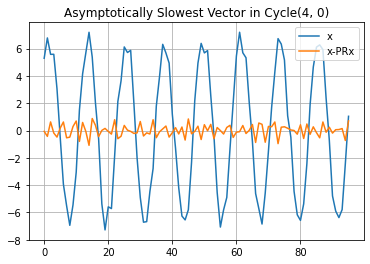

In [503]:
nu_pre = 4
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [504]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.151 -0.151  0.167  0.167]
2 lam [-0.    -0.    -0.001 -0.001 -0.019  0.045  0.045  0.061  0.061 -0.073 -0.073  0.087]


In [505]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

In [506]:
pd.DataFrame(m1[1].a.todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0320,0.0216,-0.0315,0.0540,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0016,-0.0044,-0.0342,-0.0976,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,-0.0239,-0.0312,0.0320,0.0216,-0.0315,0.0540,0.0000,0.0000,0.0000,0.0000
3,0.0490,-0.0872,0.0016,-0.0044,-0.0342,-0.0976,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,-0.0239,-0.0312,0.0320,0.0216,-0.0315,0.0540,0.0000,0.0000
5,0.0000,0.0000,0.0490,-0.0872,0.0016,-0.0044,-0.0342,-0.0976,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,-0.0239,-0.0312,0.0320,0.0216,-0.0315,0.0540
7,0.0000,0.0000,0.0000,0.0000,0.0490,-0.0872,0.0016,-0.0044,-0.0342,-0.0976
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0239,-0.0312,0.0320,0.0216
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0490,-0.0872,0.0016,-0.0044


In [507]:
pd.DataFrame((m1[1].a - m1[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,0.0199,-0.0076,0.0050,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0199,0.0000,-0.0031,-0.0105,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0076,0.0031,0.0000,0.0199,-0.0076,0.0050,0.0000,0.0000,0.0000,0.0000
3,-0.0050,0.0105,-0.0199,0.0000,-0.0031,-0.0105,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0076,0.0031,0.0000,0.0199,-0.0076,0.0050,0.0000,0.0000
5,0.0000,0.0000,-0.0050,0.0105,-0.0199,0.0000,-0.0031,-0.0105,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0076,0.0031,0.0000,0.0199,-0.0076,0.0050
7,0.0000,0.0000,0.0000,0.0000,-0.0050,0.0105,-0.0199,0.0000,-0.0031,-0.0105
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0076,0.0031,0.0000,0.0199
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0050,0.0105,-0.0199,0.0000
